# IRRmodel Water Content (model+run)

In [19]:
# Base
import os
import re
import time
import math
import numpy as np
import pandas as pd
import datetime as dtt

# Analysis
import pyswarms as ps
from scipy import special as sp
from scipy.optimize import curve_fit
from numpy.polynomial import Polynomial
from scipy.signal import savgol_filter as sfilter

# Geospatial
import fiona
import xarray as xr
import hydroeval as he
# import geopandas as gpd
# from maps_original import *

# Graphics
import seaborn as sns
import matplotlib as mplt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Snippets

## Code

### Data reading

In [2]:
# ************************************************** #
# Variables definition
# ************************************************** #

namesite = 'ITALY_BUDRIO'
siteID = '5'
namefig = namesite+'_'+siteID
# sat = input('Please provide the satellite product you want to use.'
#             +'[Options: CCI_active, SMAP, THEIA, RT1]')
# interpolate = 1 if input('Do you want to interpolate (linear) NaN gaps in satellite data? [y/n]')=='y' else 0

# ************************************************** #
# Data reading
# ************************************************** #

# Field data from TEST_SITE
df = xr.open_dataset(f'.\TEST_SITE\TEST_SITE_{namesite}.nc', engine='netcdf4').to_dataframe(); df

# Satellite data from Golden tables
golden = pd.read_csv(f'Golden_GEE.csv', delimiter = "\t")

# Budrio field data from Platinum tables
platinum = pd.ExcelFile('Platinum_Budrio.xlsx', engine='openpyxl')
platinum = platinum.parse('2017_1h')
platinum['Ora_1'] = pd.to_datetime(platinum['Ora'].astype('str')).apply(lambda x: x.time())
platinum['Data_1'] = pd.to_datetime(platinum['Data'].astype('str')).apply(lambda x: x.date())
platinum['Date'] = platinum.apply(lambda r : dtt.datetime.combine(r['Data_1'],r['Ora_1']),1)
platinum = platinum.drop(['ID', 'Data_1', 'Ora_1', '214Pb[cps]'],axis=1)

# NOTE: this dataset has to be DAILY!!
# Methods to resample timeseries-like databases: groupby, resample
# Dailiness is computed directly when extracting a given input

# Dates
D_0 = df.Time_days
D_1 = platinum['Data']
set1 = {x for x in D_0}
set2 = {x for x in D_1}
D = np.sort(np.array([*set1.intersection(set2)]))

# Other inputs
P = platinum.resample('1D',on='Date').sum()['Pioggia[mm]'].values
EPOT = df.set_index('Time_days').loc[D][f'PET_{siteID}'].values # evapotranspiration (measured)
IRR = platinum.resample('1D',on='Date').sum()['Irrigazione[mm]'].values
WWobs = platinum.resample('1D',on='Date').mean()['SWC[m3/m3]'].values

# if interpolate: WWobs = df[f'SSM_{sat}_{siteID}'].interpolate(method='linear').values
# else: WWobs = df[f'SSM_{sat}_{siteID}'].values
    # water content (observed) already interpolated on NaNs [m^3/m^3]

### 6-parameters calibration model

In [3]:
def WPSO_6(PAR, inputs):
    """Irrigation model function for its calibration.
    
    Based on KGE minimization via PSO (pyswarm) optimization.
    Version with 6 parameters to calibrate.
    
    Inputs
    ----------
    - PAR: initial guess values for parameters to calibrate
        PAR = [W_0, W_max, S_fc, S_w, rho_st, Kc]
    - inputs = [D, P, IRR, EPOT, WWobs]
    
    Return
    -------
    KGE from hydroeval
    
    """
    
    # Unpack inputs
    W_0, W_max, S_fc, S_w, rho_st, Kc = PAR
    D, P, IRR, EPOT, WWobs = inputs
    
    W_fc = S_fc*W_max # water content at field capacity
    W_w  = S_w*W_max # water content at wilting point
    Ks = [0]*len(D) # daily, water stress coefficient
    rho = [0]*len(D) # daily, depletion fraction
    PS = [0]*len(D) # daily, deep percolation
    W = [0]*len(D) # daily, water content
    W[0] = W_0*W_max
    
    for t in [i+1 for i in range(len(D)-1)]:
        rho[t]=rho_st+0.04*(5-Kc*EPOT[t])
        if W[t-1]>=(1-rho[t])*W_fc:
            Ks[t]=1
        elif (W[t-1]>W_w)and(W[t-1]<(1-rho[t])*W_fc):
            Ks[t]=float(W[t-1]-W_w)/((1-rho[t])*(W_fc-W_w))
        else: Ks[t]=0
        
        # Water balance
        W[t]=W[t-1]+P[t]+IRR[t]-EPOT[t]*Kc*Ks[t]
        
        # Computation of deep percolation (water above field capacity)
        if W[t]>W_fc:
            PS[t]=W[t]-W_fc
            W[t]=W_fc
            
    WW=np.array(W)/W_max
    OUT=he.evaluator(he.kge, WW, WWobs) # OUT is kge, r, alpha, beta
    KGE=OUT[0,:];
    
    return [KGE,WW]

#-----------------------------------------------------------------------------

def pso_calib(PAR):
    """Ausiliary function for PSO optimization"""
    global inputs
    n_particles = PAR.shape[0]
    err = np.zeros(n_particles)
    for i in range(n_particles):
        KGE,WW = WPSO_6(PAR[i], inputs)        
        err[i] = 1 - KGE
    return err

### GlobalPSO, custom # runs

Number of runs: 1
Number of particles: 100
Number of optimization steps: 100
Verbose? [true/false]false
Global or Local PSO optimizer? [global/local] global
Parameters =  [1.82184564e-01 1.20753657e+02 2.76995539e-01 1.06683875e-01
 2.55110142e-01 4.53744100e-01]
Plot parameters distributions? [y/n]n
RMSE = 0.03168805562539337
R (WW vs WWobs) = 0.8069244630633968


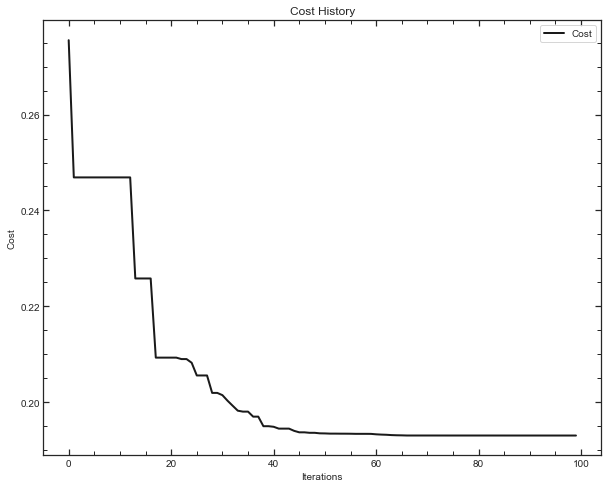

Save soil moisture - irrigation plot? [y/n]y
Please provide name of saved figure, with extension.irrig_w_v1.pdf


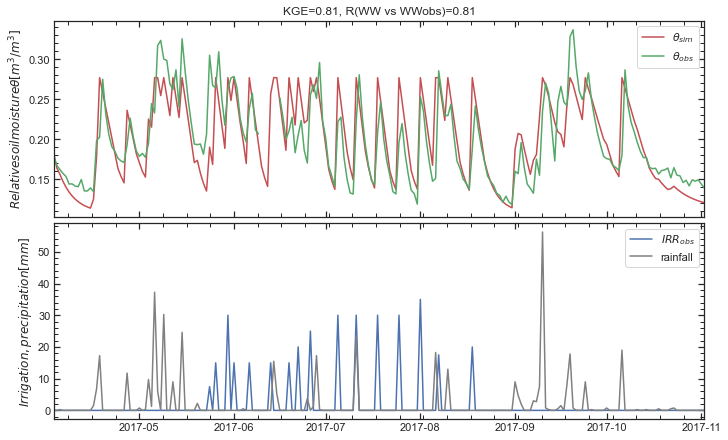

In [26]:
#-----------------------------------------------------------------------------
# Calibration run
#-----------------------------------------------------------------------------

# Initial guesses and inputs
W_0=      0.1; # [-] water content, initial??? [m^3/m^3]
W_max=    50;  # [mm] water content, maximum (not normalized)
S_fc=     0.46; # [-] field capacity [m^3/m^3] #********CHECK********
S_w=      0.08; # [-] wilting point [m^3/m^3] #********CHECK********
rho_st=   0.2; # [-] crop specific depletion fraction
Kc=       0.4; # [-] crop specific coefficient

PAR = [W_0, W_max, S_fc, S_w, rho_st, Kc] # initial guesses
inputs = [D, P, IRR, EPOT, WWobs]

#--------------START calibration
# PAR=[W_0,W_max,S_fc,S_w,rho_st,Kc];
# LOW=[  0.5,  50, .80, .01, .1, .3]';
# UP =[  0.9, 120, .95, .45, .7, .5]';
bounds = (
    np.array([  0,   0,    0, .0,  .1, .3]), # low
    np.array([  0.9, 150, .9, .3,  .7, .5]) # up
)

# Options for PSO


# Build an array of parameters to evaluate their distribution
params=[]
nrun = int(input('Number of runs: '))
n_particles = int(input('Number of particles: '))
n_step = int(input('Number of optimization steps: '))
verbose = True if input('Verbose? [true/false]')=='true' else False
optim = input('Global or Local PSO optimizer? [global/local] ')
if optim=='local': norm = 1 if input('Which norm? [l1/l2] ')=='l1' else 2

for i in range(int(nrun)):
    if optim=='global':
        options = {'c1': 0.4, 'c2': 0.4, 'w': 0.8}
        optimizer = ps.single.GlobalBestPSO(n_particles=int(n_particles), dimensions=len(PAR), options=options, bounds=bounds)
    elif optim=='local':
        options = {'c1': 0.4, 'c2': 0.4, 'w': 0.8, 'k':int(0.1*n_particles), 'p':norm }
        optimizer = ps.single.LocalBestPSO(n_particles=n_particles, dimensions=len(PAR), options=options, bounds=bounds)
    else: raise NameError('Please provide an accepted option.')
    cost, PARn = optimizer.optimize(pso_calib, n_step, verbose=verbose)
    params.append(PARn)
    i+=1

#------------- model run validation
KGE,WW = WPSO_6(PARn, inputs)
print("Parameters = ", PARn)

#-----------------------------------------------------------------------------
# Study distribution of parameters
#-----------------------------------------------------------------------------
matrix = np.array([ np.array([ params[i][j] for i in range(len(params)) ])
        for j in range(len(params[0])) ])

if input('Plot parameters distributions? [y/n]')=='y':
    for i in range(len(matrix)):
        plt.hist(matrix[i])
        plt.show()

# ***************************************************** #
# Model performance
# ***************************************************** #
RMSE=np.nanmean((WW-WWobs)**2)**0.5; print('RMSE =', RMSE)
NS=1-np.nansum((WW-WWobs)**2)/np.nansum((WWobs-np.nanmean(WWobs))**2)
NS_radQ=1-np.nansum((np.sqrt(WW+0.00001)-np.sqrt(WWobs+0.00001))**2)/np.nansum((np.sqrt(WWobs+0.00001)-np.nanmean(np.sqrt(WWobs+0.00001)))**2)
NS_lnQ=1-np.nansum((np.log(WW+0.0001)-np.log(WWobs+0.0001))**2)/np.nansum((np.log(WWobs+0.0001)-np.nanmean(np.log(WWobs+0.0001)))**2)
NS_lnQ=NS_lnQ.real; # print(NS_lnQ) 
NS_radQ=NS_radQ.real; # print(NS_radQ)

# R coefficient score
WWmatrix = np.array( [ [WW[i], WWobs[i]] for i in range(len(WW)) if not np.isnan(WWobs[i]) ] )
R=np.corrcoef(WWmatrix,rowvar=False)[0][1]; print('R (WW vs WWobs) =', R)

# Optimizer performance and plot cost history
from pyswarms.utils.functions.single_obj import sphere
from pyswarms.utils.plotters import plot_cost_history

cost_history = optimizer.cost_history
plot_cost_history(cost_history)
plt.show()

# ***************************************************** #
# Figure
# ***************************************************** #
fig, ax = plt.subplots(2, 1,
                       constrained_layout=True,
                       figsize=(10, 6), sharex=True)

# f'{a:.2f}'
ax[0].set_title(f'KGE={KGE[0]:.2f}, R(WW vs WWobs)={R:.2f}')
ax[0].set_xlim(xmin=D[0], xmax=D[len(D)-1])
ax[0].plot(D, WW, c='r', label=r'$\theta_{sim}$')
ax[0].plot(D, WWobs, c='g', label=r'$\theta_{obs}$')
ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$Relative soil moisture \theta [m^3/m^3]$')

ax[1].plot(D, IRR, c='b', label=r'$IRR_{obs}$')
ax[1].plot(D, P, c='gray', label=r'rainfall')
ax[1].legend(loc='upper right')
ax[1].set_ylabel('$Irrigation, precipitation [mm]$')

if input('Save soil moisture - irrigation plot? [y/n]')=='y':
    fname = input('Please provide name of saved figure, with extension.')
    plt.savefig(fname)

In [27]:
R

0.8069244630633968

In [14]:
KGE

array([0.80593384])